# CNN anjing dan Kucing

# Import Library

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader 

import os
import struct
import numpy as np
import glob
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(),dtype=np.unit8).reshape(shape)

# load data set

In [17]:
from torch.utils.data import Dataset
from torchvision import transforms


class KucingAnjingDataset(Dataset):

	def __init__(self, root_dir, random_seed=42, image_size=224):

		self.root_dir = root_dir
		self.image_size = image_size

		if not os.path.exists(self.root_dir):
			raise RuntimeError(f"Dataset not found at {self.root_dir}.")


		self.transform = transforms.Compose([
        	transforms.Resize((self.image_size, self.image_size)),
        	transforms.ToTensor(),
        	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

		self.data = []
		self.labels = []

		for label, class_name in tqdm(enumerate(['cats','dogs'])):
			class_dir = os.path.join(self.root_dir, class_name)
			image_paths = glob.glob(os.path.join(class_dir,'*.jpg'))
			self.data.extend(image_paths)
			self.labels.extend([label] * len(image_paths))

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		image_path = self.data[idx]
		label = self.labels[idx]
		image = Image.open(image_path).convert('RGB')

		if self.transform:
			image = self.transform(image)

		return image, label


# model cnn

In [18]:
class  ModelCNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
   

In [19]:
batch_size = 32
test_batch_size = 32
train_dataset = KucingAnjingDataset(root_dir='/kaggle/input/cat-and-dog/training_set/training_set')
test_dataset  = KucingAnjingDataset(root_dir='/kaggle/input/cat-and-dog/test_set/test_set')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset))
# model = ModelCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

2it [00:00, 17.33it/s]
2it [00:00, 48.24it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


Total parameters: 15.28M
Trainable parameters: 15.28M


100%|██████████| 64/64 [00:22<00:00,  2.81it/s]


Epoch 1: Train Loss 0.8355, Test Loss 0.0743, Test Acc 0.9852


100%|██████████| 64/64 [00:09<00:00,  6.70it/s]


Epoch 2: Train Loss 0.0281, Test Loss 0.0471, Test Acc 0.9847


100%|██████████| 64/64 [00:08<00:00,  7.15it/s]


Epoch 3: Train Loss 0.0135, Test Loss 0.0538, Test Acc 0.9867


100%|██████████| 64/64 [00:08<00:00,  7.35it/s]


Epoch 4: Train Loss 0.0151, Test Loss 0.0580, Test Acc 0.9832


100%|██████████| 64/64 [00:08<00:00,  7.35it/s]


Epoch 5: Train Loss 0.0155, Test Loss 0.0627, Test Acc 0.9822


100%|██████████| 64/64 [00:09<00:00,  6.94it/s]


Epoch 6: Train Loss 0.0270, Test Loss 0.0816, Test Acc 0.9778


100%|██████████| 64/64 [00:08<00:00,  7.30it/s]


Epoch 7: Train Loss 0.0281, Test Loss 0.0537, Test Acc 0.9812


100%|██████████| 64/64 [00:08<00:00,  7.25it/s]


Epoch 8: Train Loss 0.0046, Test Loss 0.0460, Test Acc 0.9881


100%|██████████| 64/64 [00:08<00:00,  7.19it/s]


Epoch 9: Train Loss 0.0043, Test Loss 0.0562, Test Acc 0.9871


100%|██████████| 64/64 [00:09<00:00,  6.98it/s]

Epoch 10: Train Loss 0.0010, Test Loss 0.0466, Test Acc 0.9891


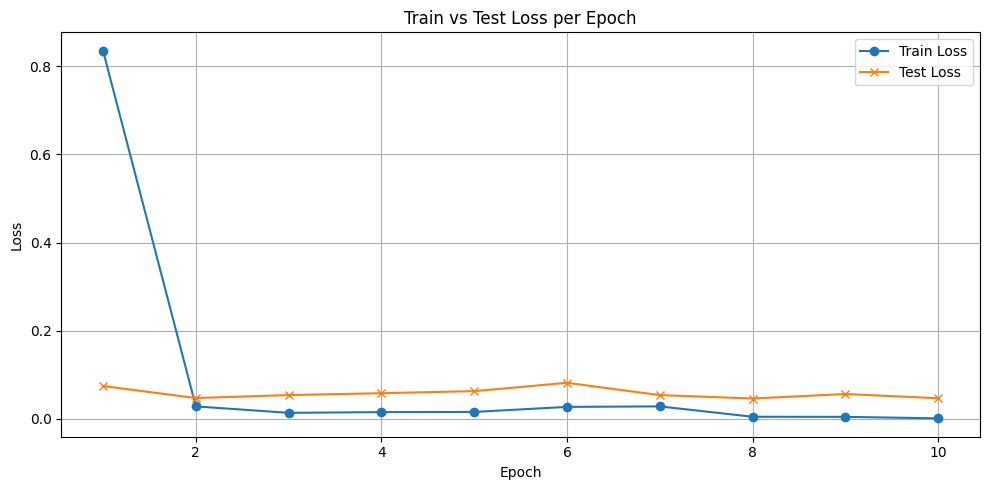

In [20]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'cat_dog_checkpoint.pth')

epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()